In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymaid
import logging
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from pkg.platy import _get_folder, load_left_adj_orig, load_right_adj_orig, load_connectome_normal_lcc_annotations, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2

Grab Nadine's pairs: these are the true pairs

In [5]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [6]:
left_adj = load_left_adj_orig()
right_adj = load_right_adj_orig()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

print(len(left_adj))
print(len(right_adj))

1355
1340


In [7]:
left_skids = left_adj.index
right_skids = right_adj.index

Run graph matching without any initialization of the matrices

In [8]:
#WHOLE, DEFAULT, OPT
ind_left, ind_right, score, misc = graph_match(np_left_adj, np_right_adj)

In [9]:
#score from WHOLE DEFAULT OPT
score

21077.0

(<AxesSubplot:>,
 <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x13720d100>)

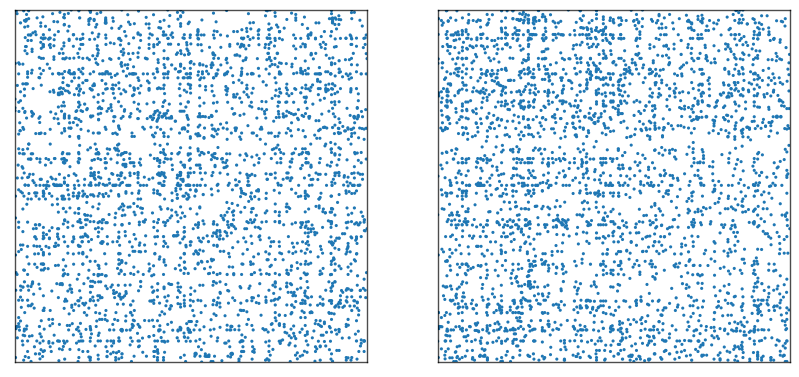

In [10]:
import seaborn as sns
from graspologic.plot import adjplot

fig, axs = plt.subplots(1,2,figsize=(10, 5))
adjplot(np_left_adj[ind_left][:, ind_left], plot_type='scattermap', ax=axs[0])
adjplot(np_right_adj[ind_right][:, ind_right], plot_type='scattermap', ax=axs[1])

Permute the skids based on graph matching, this gives us the pairs from graph matching

In [11]:
left_matched_skids = left_skids[ind_left]
right_matched_skids = right_skids[ind_right]

#make dataframe for the matched pairs
matched_pairs = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
matched_pairs

,skid-ID LEFT,skid-ID RIGHT
0,2015233,1688689
1,1548290,1123964
2,1318919,1307247
3,2015241,1282965
4,1318929,766682
...,...,...
1335,1368040,1670927
1336,1277932,1314140
1337,1302513,1355911
1338,1630186,1992051


Calculating the accuracy of how graph matching did (compare our pairs to Nadine's pairs)

In [12]:
#merge the true pairs and our matched pairs by their union
df = pd.merge(true_pairs, matched_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = df[df.duplicated("skid-ID LEFT")]
duplicate_R = df[df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))
df

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.02242152466367713


,index,skid-ID LEFT,skid-ID RIGHT,Exist
0,0.0,7501,25010,left_only
1,1.0,10536,26163,left_only
2,2.0,6743,23921,left_only
3,3.0,151847,27064,left_only
4,4.0,12115,27917,left_only
...,...,...,...,...
1618,NaN,1368040,1670927,right_only
1619,NaN,1277932,1314140,right_only
1620,NaN,1302513,1355911,right_only
1621,NaN,1630186,1992051,right_only


In [13]:
df1 = pd.DataFrame({'L': [1, 2, 3, 4, 5, 6, 7, 8], 'R': ["a", "b", "c", "d", "e", "f", "g", "h"]})
df2 = pd.DataFrame({'L': [1, 3, 12, 9, 10, 11, 2, 4, 6, 5], 'R': ["a", "d", "h", "r", "w", "u", "b", "d", "q", "c"]})
print(df1)
print(df2)

   L  R
0  1  a
1  2  b
2  3  c
3  4  d
4  5  e
5  6  f
6  7  g
7  8  h
    L  R
0   1  a
1   3  d
2  12  h
3   9  r
4  10  w
5  11  u
6   2  b
7   4  d
8   6  q
9   5  c


In [14]:
new_df = pd.merge(df1, df2, on=["L", 'R'], how="outer", indicator="exist")
test_num = new_df["exist"].value_counts()["both"]
duplicate_L = new_df[new_df.duplicated(['L'])]
duplicate_R = new_df[new_df.duplicated(['R'])]
new_df

,L,R,exist
0,1,a,both
1,2,b,both
2,3,c,left_only
3,4,d,both
4,5,e,left_only
5,6,f,left_only
6,7,g,left_only
7,8,h,left_only
8,3,d,right_only
9,12,h,right_only


In [15]:
print(duplicate_L)
print(duplicate_R)
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["L", "R"], how="outer", indicator="Exist")
acc = test_num / (test_num + len(duplicate_df))
print(acc)
duplicate_df

    L  R       exist
8   3  d  right_only
13  6  q  right_only
14  5  c  right_only
     L  R       exist
8    3  d  right_only
9   12  h  right_only
14   5  c  right_only
0.42857142857142855


,L,R,exist_x,exist_y,Exist
0,3,d,right_only,right_only,both
1,6,q,right_only,NaN,left_only
2,5,c,right_only,right_only,both
3,12,h,NaN,right_only,right_only


Calculate the norm of the difference of the two adjacencies after permuting the skids

In [16]:
#norms of matched adjs
#subset and permute the adjacencies by their indices from matching
np_left_adj_matched = np_left_adj[np.ix_(ind_left, ind_left)]
np_right_adj_matched = np_right_adj[np.ix_(ind_right, ind_right)]

#calculate norm of difference of matched adjacencies
np_diff_adj_matched = np_left_adj_matched - np_right_adj_matched
diff_matched_norm = np.linalg.norm(np_diff_adj_matched)

print(f"Norm of difference of left and right matched adjs: {diff_matched_norm}")

Norm of difference of left and right matched adjs: 166.82325976913413


In [17]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_whole = []
rng = default_rng()
for _ in range(n_iters):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_left_adj), size=len(np_right_adj), replace=False)
    np_left_adj_rand = np_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_right_adj), size=len(np_right_adj), replace=False)
    np_right_adj_rand = np_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_diff_adj_rand = np_left_adj_rand - np_right_adj_rand
    diff_rand_norm = np.linalg.norm(np_diff_adj_rand)
    rand_norms_whole.append(diff_rand_norm)


Plot histogram showing how our norm compares to the norms after random permutations of the matrices

Text(0.5, 1.0, 'Norm of difference of matched (on whole adjs) vs random adjacencies (matched norm: 166.82325976913413)')

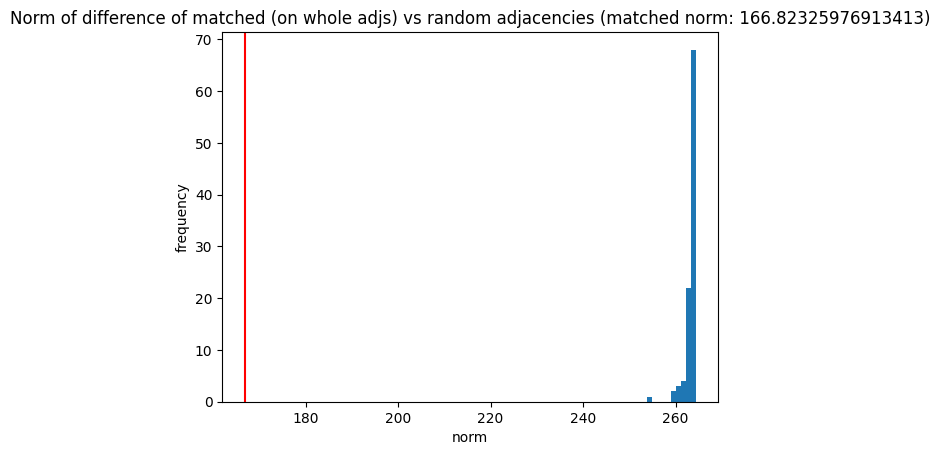

In [18]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole)
ax.axvline(diff_matched_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on whole adjs) vs random adjacencies (matched norm: {})".format(diff_matched_norm))

Look at morphologies of neurons that were paired correctly, 5 morphologies of neurons that were paired correctly in only Nadine's, and 5 morphologies of neurons that were paired in ours

In [19]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [20]:
#look at correct morphologies
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list_both = []
neuron_list_nadine = []
neuron_list_ours = []

for ind, row in df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]

    #when the pair exists in both our list and Nadine's list
    if(row["Exist"] == "both"):
        neuron_list_both.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in Nadine's list only
    elif(row["Exist"] == "left_only" and len(neuron_list_nadine)<=5):
        neuron_list_nadine.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in our list only
    elif(row["Exist"] == "right_only" and len(neuron_list_ours)<=5):
        neuron_list_ours.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

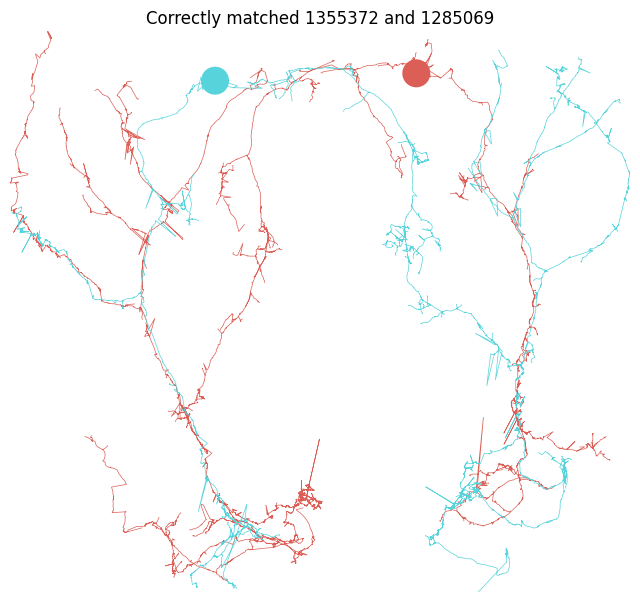

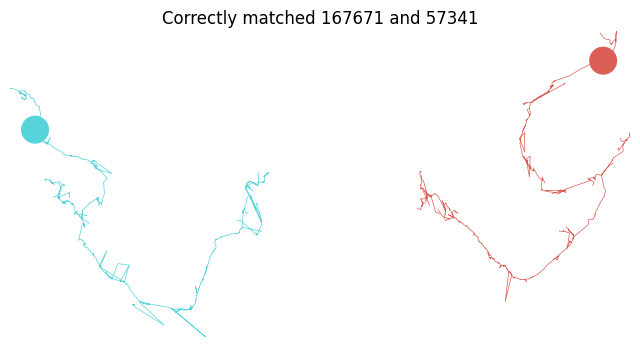

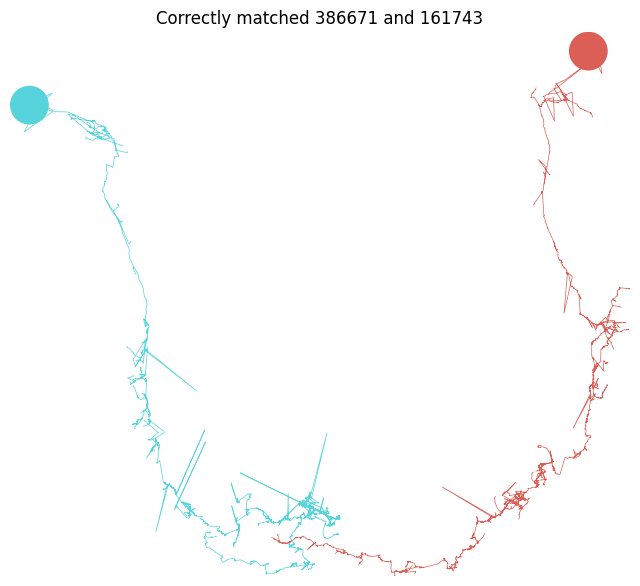

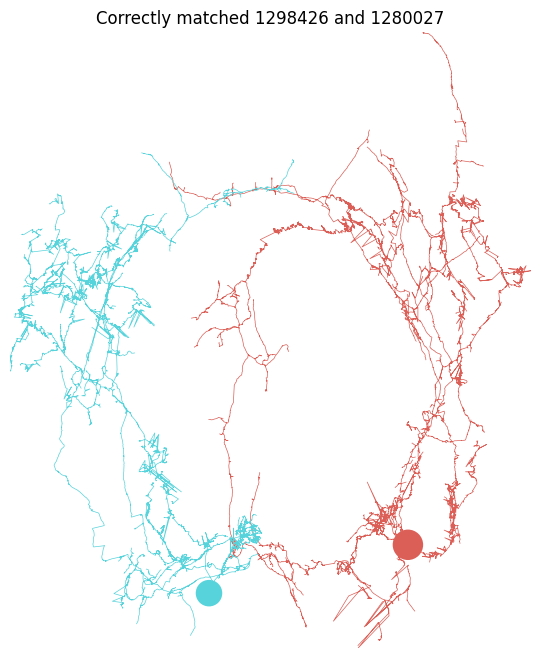

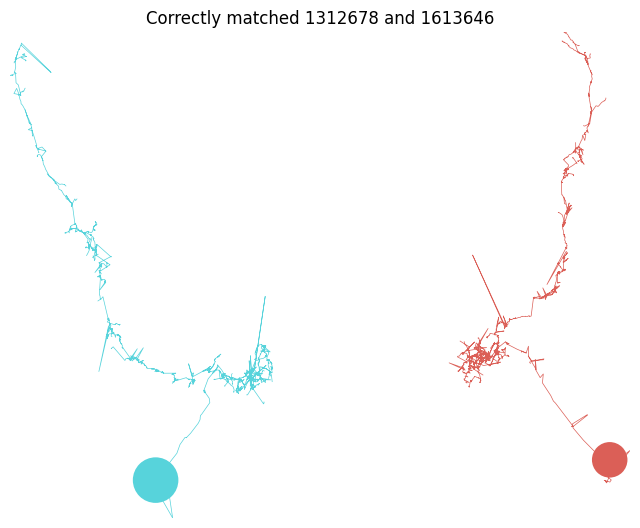

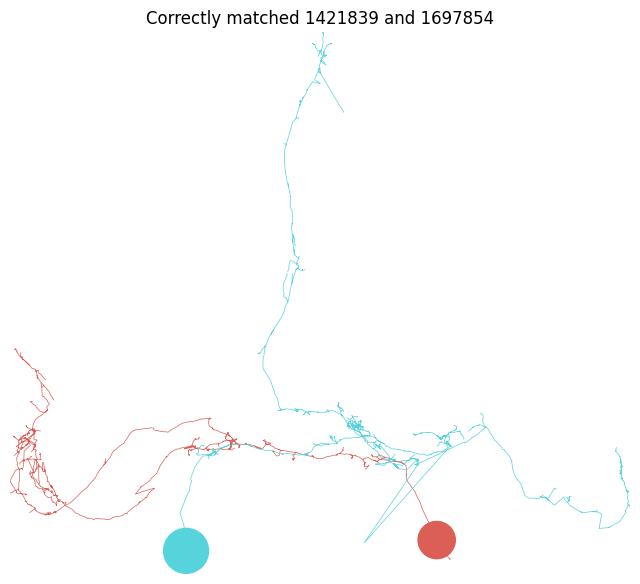

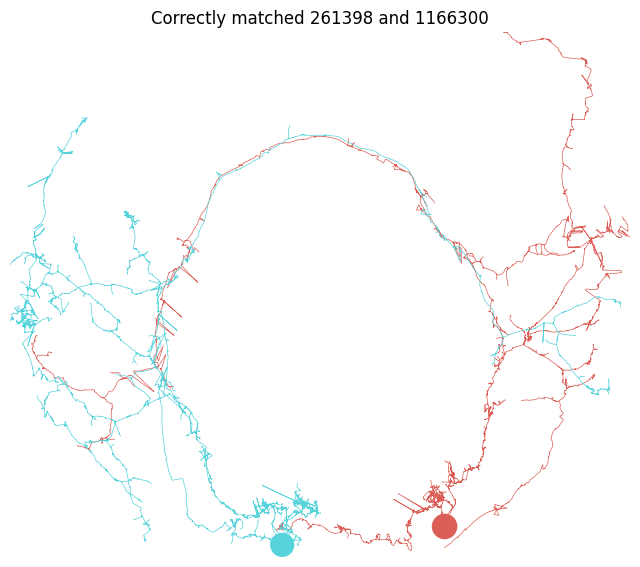

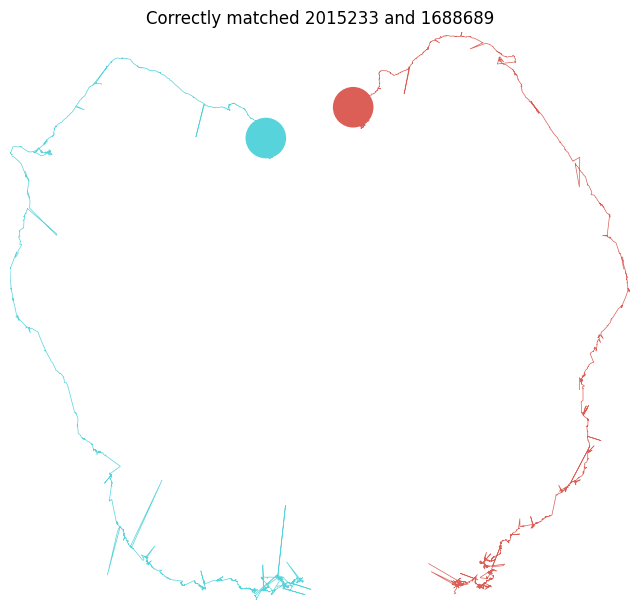

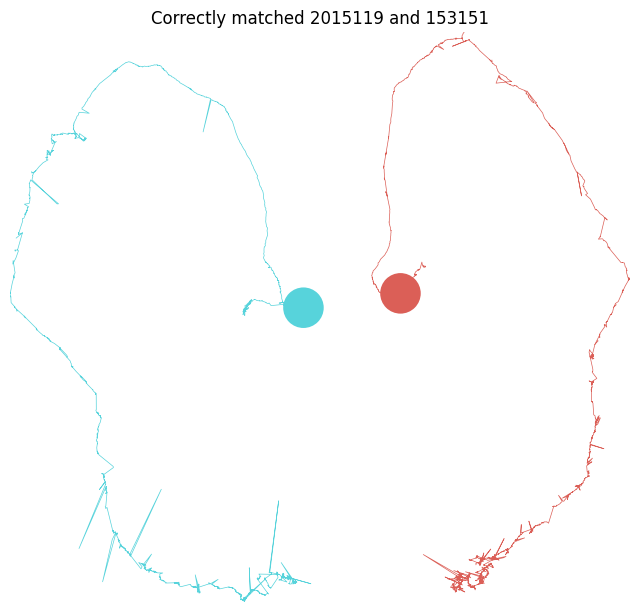

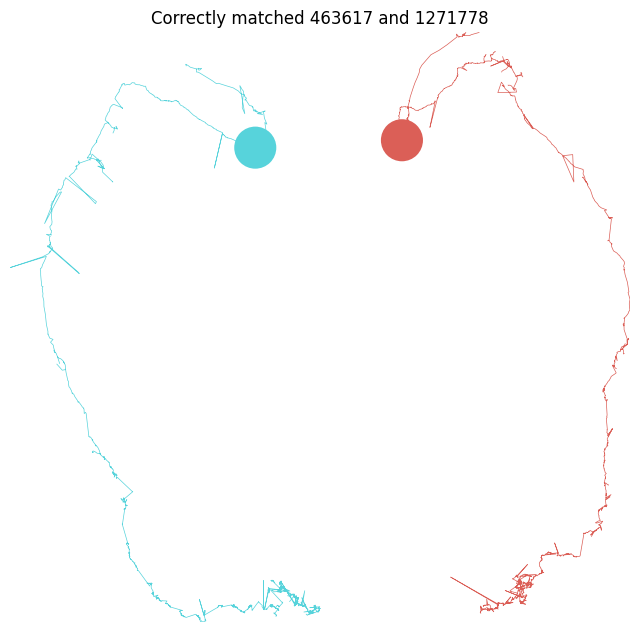

In [21]:
#visualize correctly matched neurons
for i in range(len(neuron_list_both)):
    fig, ax = navis.plot2d(neuron_list_both[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_both[i][1]
    right = neuron_list_both[i][2]
    ax.set_title(f"Correctly matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

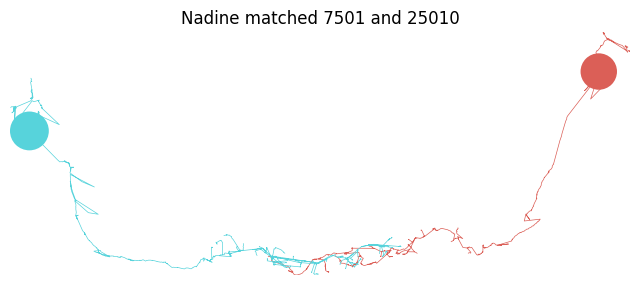

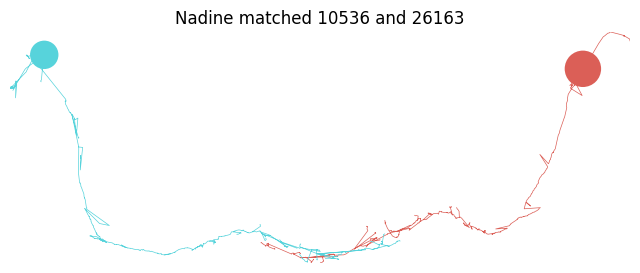

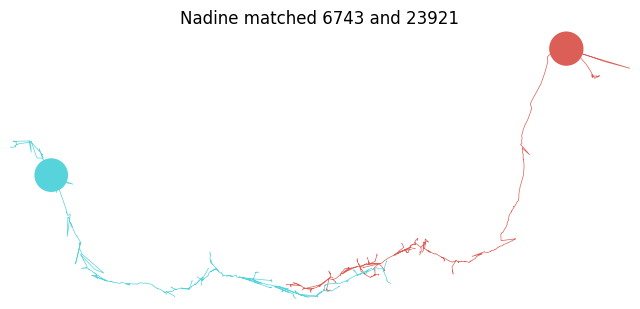

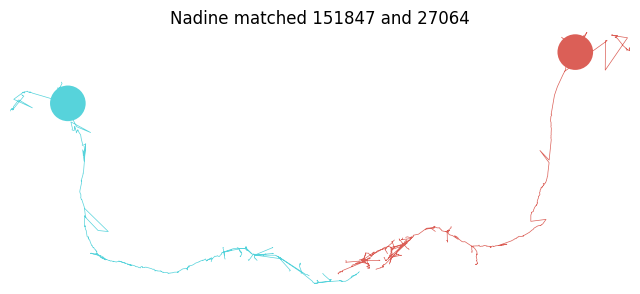

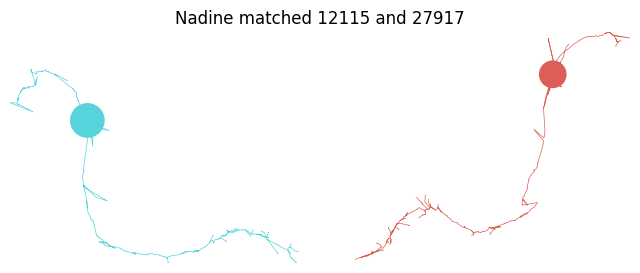

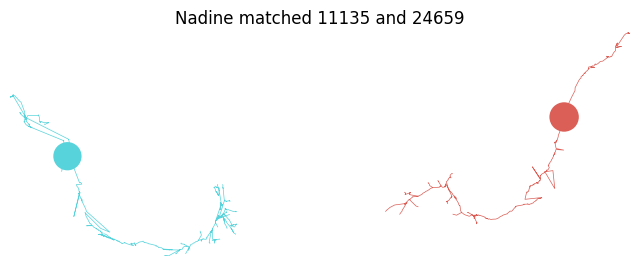

In [22]:
#visualize neurons that nadines matched that was not in ours
for i in range(len(neuron_list_nadine)):
    fig, ax = navis.plot2d(neuron_list_nadine[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_nadine[i][1]
    right = neuron_list_nadine[i][2]
    ax.set_title(f"Nadine matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

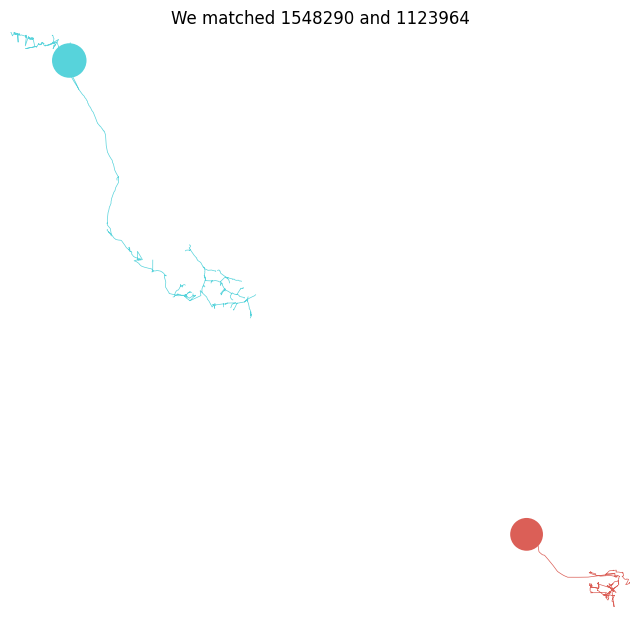

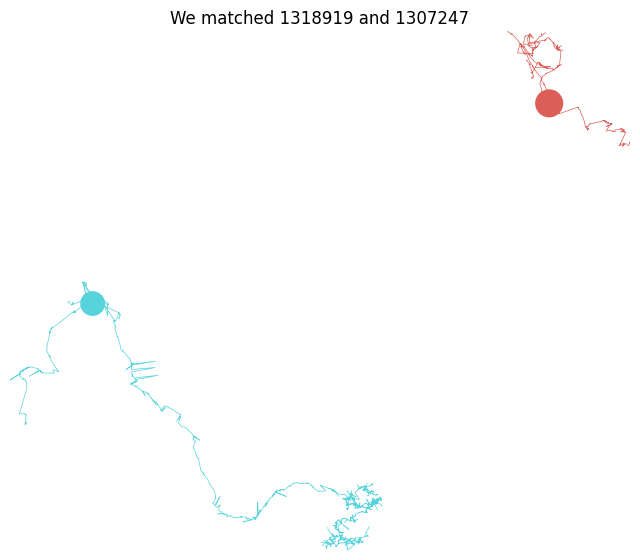

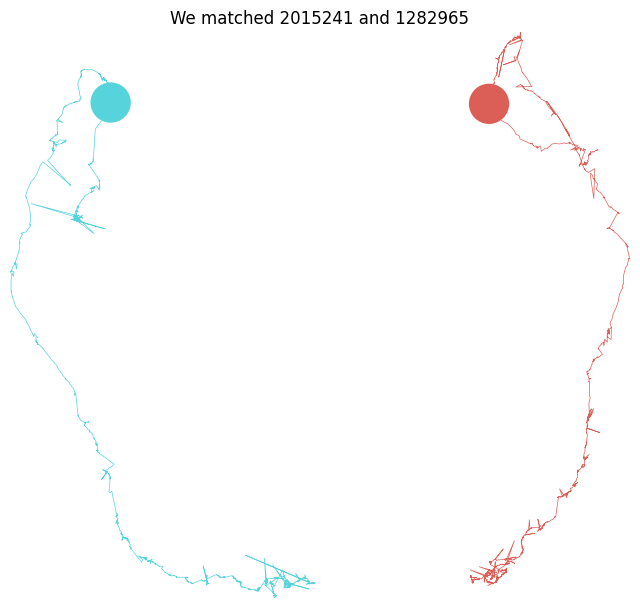

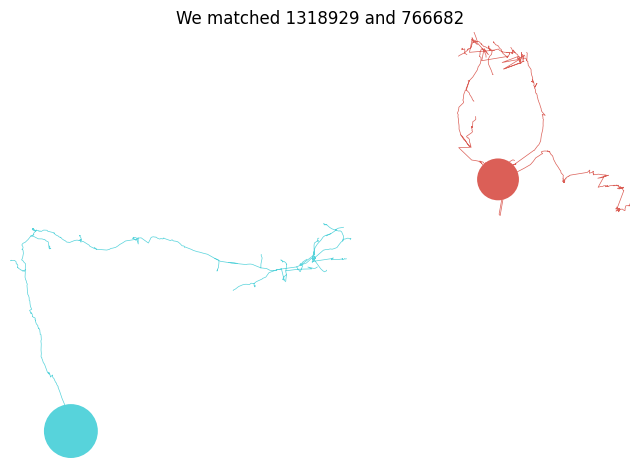

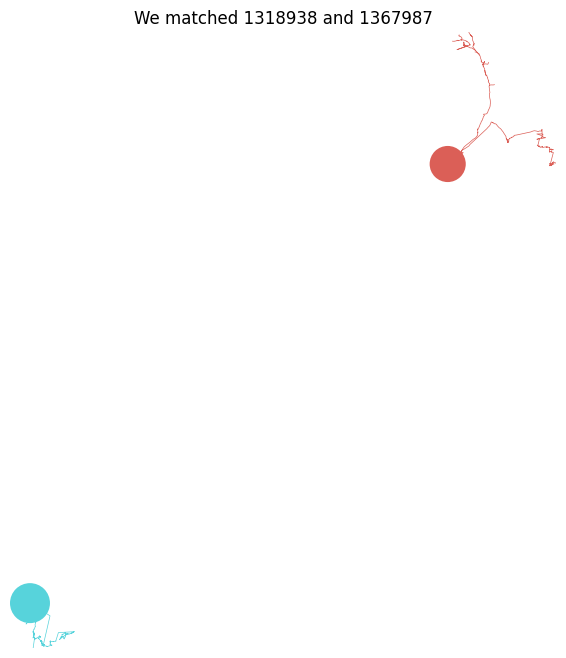

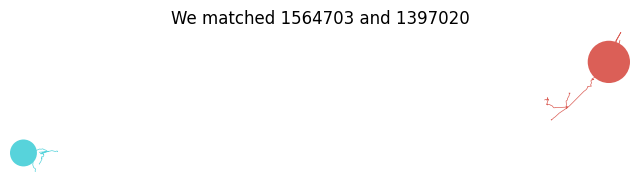

In [23]:
#visualize neurons that we matched that nadine did not
for i in range(len(neuron_list_ours)):
    fig, ax = navis.plot2d(neuron_list_ours[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_ours[i][1]
    right = neuron_list_ours[i][2]
    ax.set_title(f"We matched {left} and {right}")

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [24]:
#first move all the left skids that are in Nadine's list to the front of the left skids list
left_skids_copy = np.array(left_skids)

#find left indices that correspond to Nadine's list
inds_nadine = [list(np.where(left_skids_copy == j)[0]) for j in left_true]

#modify inds_nadine to get rid of all empty lists (skids that exist in Nadine's skid list but not ours) and make list elements as ints
inds_nadine_filt = [ele[0] for ele in inds_nadine if ele != []]
inds_nadine_filt = np.array(inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in left_skids_copy
skids_left_nadine = left_skids_copy[inds_nadine_filt]
skids_left_not_nadine = [skid for skid in left_skids_copy if skid not in skids_left_nadine]
skids_left_not_nadine = np.array(skids_left_not_nadine)

#now concatenate the nadine skids and not_nadine left skids
skids_left_form = np.append(skids_left_nadine, skids_left_not_nadine, axis=0)

#now permute the right index list such that the pairs align with Nadine's
right_skids_copy = np.array(right_skids)

#go through the first entires of left_skids_copy and find the right_skid that corresponds to it in true_pairs
for i in range(len(inds_nadine_filt)):

    #find the index where the current left skid appears in true pairs
    ind_pair = true_pairs.loc[true_pairs["skid-ID LEFT"] == skids_left_form[i]].index[0]

    #find the right skid that corresponds to the left_skid in true pairs
    right_skid = true_pairs.loc[ind_pair, "skid-ID RIGHT"]

    #find where this right_skid is in our right_skids list, if it is not there then continue
    if right_skid not in right_skids_copy:
        continue
    
    else:
        
        #swap right_skid with the skid where it needs to go
        ind_right_curr = np.where(right_skids_copy == right_skid)[0][0]
        temp = right_skids_copy[i]
        right_skids_copy[i] = right_skid
        right_skids_copy[ind_right_curr] = temp
        
skids_right_form = right_skids_copy.copy()


Calculate the accuracy of our permuted left and right skids do (without running graph matchingf)

In [25]:
#Accuracy of WHOLE, NADINE, NADINE
whole_nadine_nadine_pairs = pd.DataFrame(list(zip(skids_left_form, skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
whole_nadine_nadine_pairs

#merge the true pairs and our matched pairs by their union
whole_nadine_df = pd.merge(true_pairs, whole_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = whole_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.8817204301075269


Calculate the norms of the left and right adjs after permuting the skids (no graph matching)

In [26]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
skids_left_form_trunc = skids_left_form[0:len(skids_right_form)]

#make adjs
whole_nadine_left_adj = pymaid.adjacency_matrix(skids_left_form)
whole_nadine_left_adj_trunc = pymaid.adjacency_matrix(skids_left_form_trunc)
whole_nadine_right_adj = pymaid.adjacency_matrix(skids_right_form)

np_whole_nadine_left_adj = np.array(whole_nadine_left_adj)
np_whole_nadine_left_adj_trunc = np.array(whole_nadine_left_adj_trunc)
np_whole_nadine_right_adj = np.array(whole_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_whole_nadine = np_whole_nadine_left_adj_trunc - np_whole_nadine_right_adj
diff_whole_nadine_norm = np.linalg.norm(np_diff_whole_nadine)

print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_norm}")

Norm of difference of left and right matched adjs: 244.05737030460688


In [27]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_whole_nadine = []
rng = default_rng()
for _ in range(n_iters):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj_trunc), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of matched (on whole adjs) vs random adjacencies (norm: 244.05737030460688)')

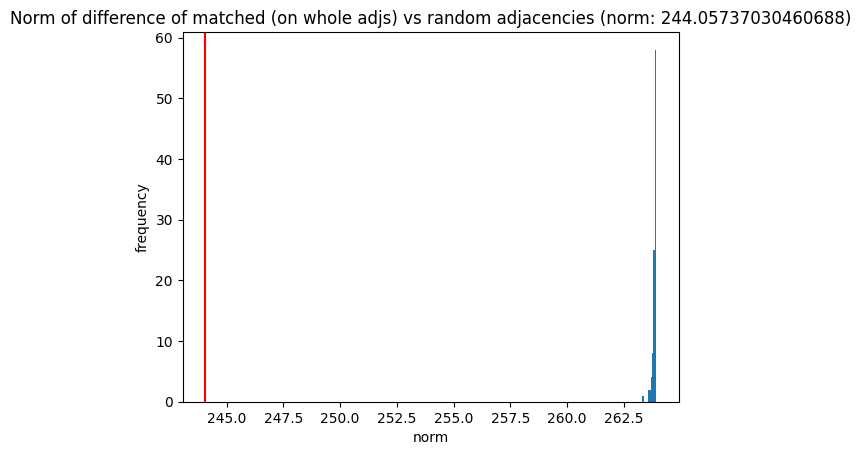

In [28]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on whole adjs) vs random adjacencies (norm: {})".format(diff_whole_nadine_norm))

Run graph matching on our permuted adjs

In [29]:
#WHOLE, NADINE, OPT
whole_nadine_ind_left, whole_nadine_ind_right, score, _ = graph_match(np_whole_nadine_left_adj, np_whole_nadine_right_adj)

In [30]:
#score from WHOLE NADINE OPT
score

21766.0

In [31]:
skids_left_form_matched = skids_left_form[whole_nadine_ind_left]
skids_right_form_matched = skids_right_form[whole_nadine_ind_right]

#make dataframe for the matched pairs
whole_nadine_matched_pairs = pd.DataFrame(list(zip(skids_left_form_matched, skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
whole_nadine_matched_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,1663434
1,10536,1489841
2,6743,1928926
3,151847,1442572
4,12115,2011670
...,...,...
1335,1368040,1420539
1336,1277932,1285768
1337,1302513,1355911
1338,1630186,1829048


Calculate the accuracy after running graph matching on our permuted adjs

In [32]:
#WHOLE, NADINE, OPT

#merge the true pairs and our matched pairs by their union
whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = whole_nadine_matched_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.016018306636155607


Calculate norm from running graph matching on our permuted adjs

In [33]:
#norms of whole nadine init opt adjs

#subset and permute the adjacencies by their indices from matching
np_whole_nadine_matched_left_adj = np_whole_nadine_left_adj[np.ix_(whole_nadine_ind_left, whole_nadine_ind_left)]
np_whole_nadine_matched_right_adj = np_whole_nadine_right_adj[np.ix_(whole_nadine_ind_right, whole_nadine_ind_right)]

#calculate norm of difference of matched adjacencies
np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)

print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 162.63148526653748


In [34]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_whole_nadine = []
rng = default_rng()
for _ in range(n_iters):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of matched (on whole adjs) vs random adjacencies (matched norm: 162.63148526653748)')

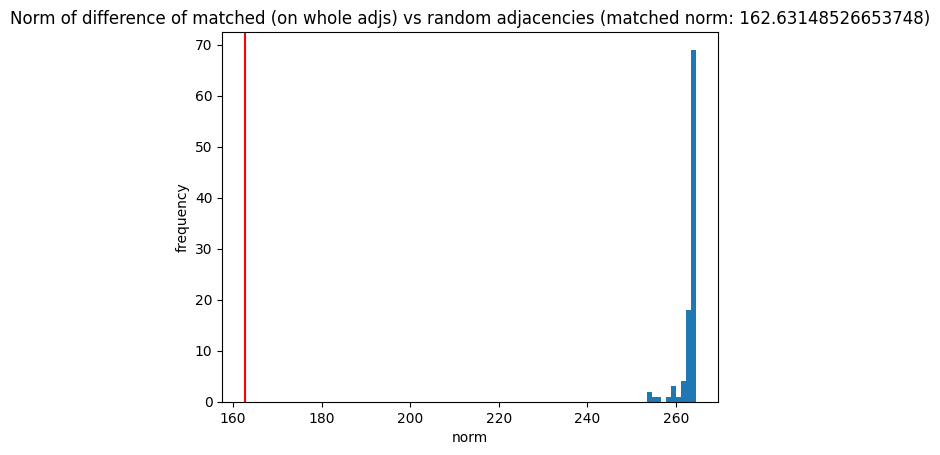

In [35]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_nadine_matched_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on whole adjs) vs random adjacencies (matched norm: {})".format(diff_whole_nadine_matched_norm))

Do all the same analyses, but run on the subgraph (from our total list of left and right neurons, use the subsets of the neurons that exist in true pairs)

In [36]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

pd_sub_left_skids = pd.Series(sub_left_skids)
pd_sub_right_skids = pd.Series(sub_right_skids)

print(len(sub_left_skids))
print(len(sub_right_skids))

266
260


In [37]:
sub_left_adj = pymaid.adjacency_matrix(sub_left_skids)
sub_right_adj = pymaid.adjacency_matrix(sub_right_skids)

np_sub_left_adj = np.array(sub_left_adj)
np_sub_right_adj = np.array(sub_right_adj)


Run graph matching without any initialization

In [38]:
#SUB, DEFAULT, OPT
sub_ind_left, sub_ind_right, sub_score, sub_misc = graph_match(np_sub_left_adj, np_sub_right_adj)

In [39]:
#Score from SUB, DEFAULT, OPT
sub_score

5266.0

Permute our lists of skids based on the results of graph matching

In [40]:
sub_left_matched_skids = pd_sub_left_skids[sub_ind_left]
sub_right_matched_skids = pd_sub_right_skids[sub_ind_right]

#make dataframe for the matched pairs
sub_matched_pairs = pd.DataFrame(list(zip(sub_left_matched_skids, sub_right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
sub_matched_pairs

,skid-ID LEFT,skid-ID RIGHT
0,2015233,1072496
1,1278006,1420237
2,1278038,269876
3,1278051,486654
4,385141,68613
...,...,...
255,1163030,1294413
256,1408867,1312505
257,139142,1704627
258,2015119,1274799


Calculate the accuracy on our subgraphs after graph matching without initialization

In [41]:
#merge the true pairs and our matched pairs by their union
sub_df = pd.merge(true_pairs, sub_matched_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
sub_num = sub_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_df[sub_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_df[sub_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
sub_den = len(duplicate_df) + sub_num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(sub_num/sub_den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.06538461538461539


Collect the neurons that were correctly matched from graph matching

In [42]:
correct_sub_df = sub_df.loc[sub_df["Exist"] == "both"]
correct_sub_df = correct_sub_df.reset_index()
correct_sub_df

,level_0,index,skid-ID LEFT,skid-ID RIGHT,Exist
0,49,69.0,1075718,1077309,both
1,50,70.0,508114,1285696,both
2,77,160.0,386671,161743,both
3,78,161.0,1298426,1280027,both
4,84,168.0,1295517,715837,both
5,95,205.0,1729648,1307524,both
6,100,221.0,1850496,1845760,both
7,106,227.0,1678918,369396,both
8,146,337.0,1361174,1361146,both
9,153,344.0,1730785,1756581,both


Visualize the correctly matched neurons

In [43]:
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list = []
for ind, row in correct_sub_df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]
    neuron_list.append(pymaid.get_neuron(neurons))

neuron_list

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

[<class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (98.0KiB)
             type                    name skeleton_id  n_nodes  n_connectors  \
 0  CatmaidNeuron  SNPDF-dc_l1_DLSO1.1_4l     1075718     1420            16   
 1  CatmaidNeuron  SNPDF-dc_r1_DLSO1.1_4r     1077309     1681            17   
 
    n_branches  n_leafs  cable_length       soma        units  
 0          59       62   283754.3125  [1089674]  1 nanometer  
 1          71       79   341822.4375  [1078803]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (95.1KiB)
             type                   name skeleton_id  n_nodes  n_connectors  \
 0  CatmaidNeuron  SN-DLSO1.2_4lPDF-dcl2      508114     1417             9   
 1  CatmaidNeuron  SN-DLSO1.2_4rPDF-dcr3     1285696     1609             6   
 
    n_branches  n_leafs   cable_length       soma        units  
 0          65       70  247071.203125   [450478]  1 nanometer  
 1          67       72  264699.437500  [1354271]  1

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

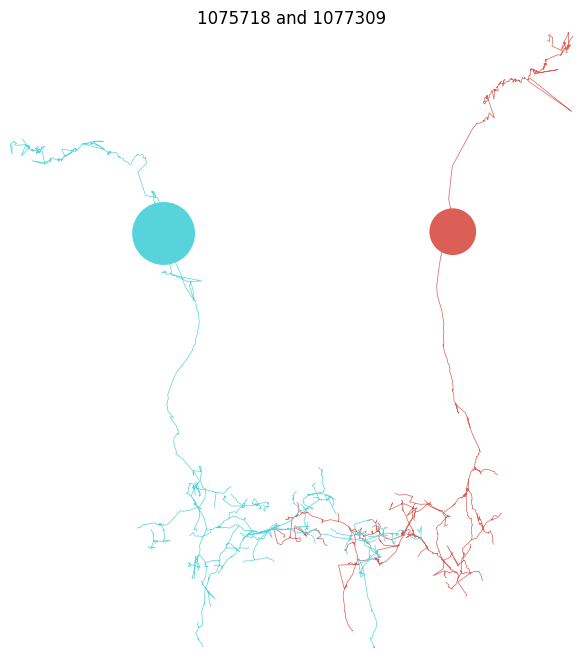

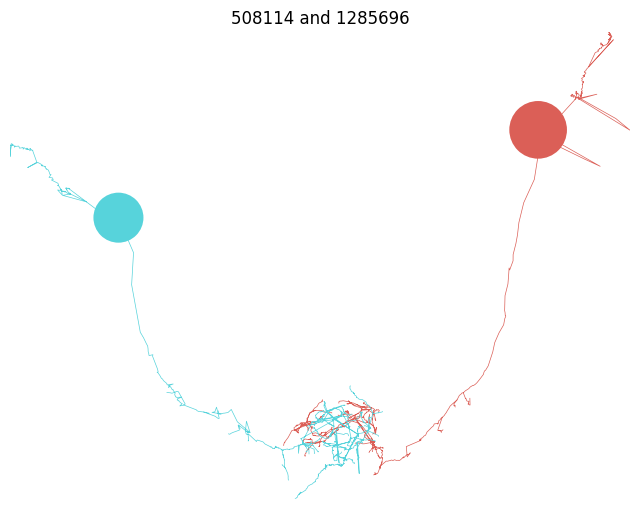

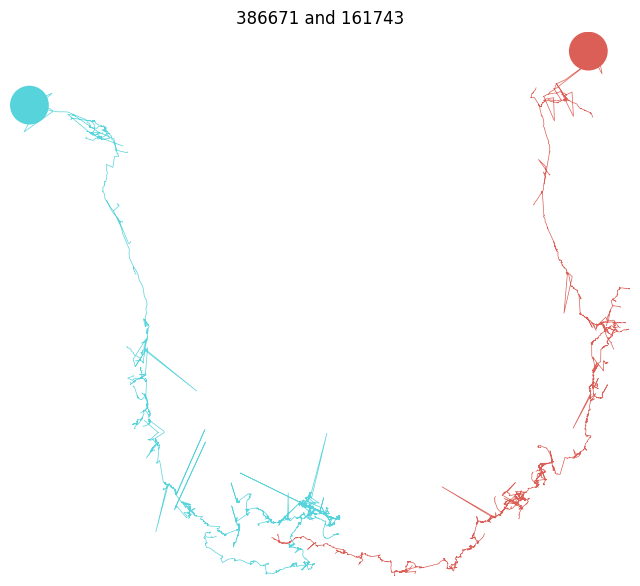

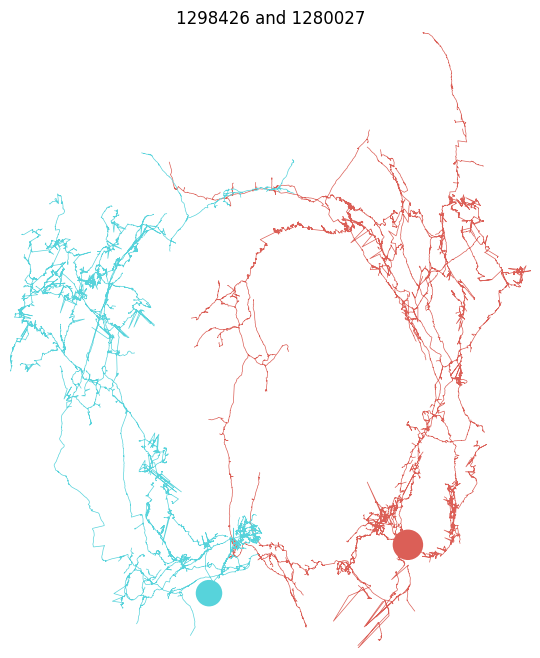

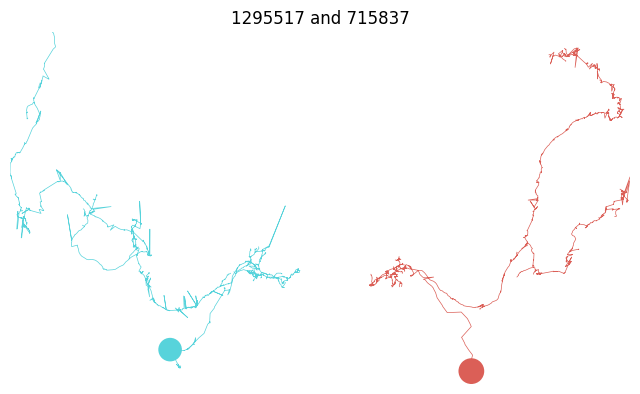

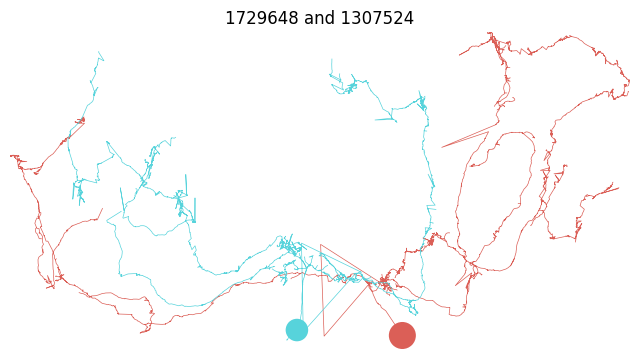

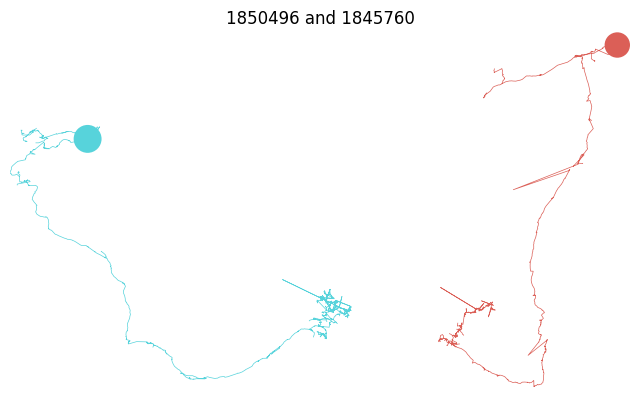

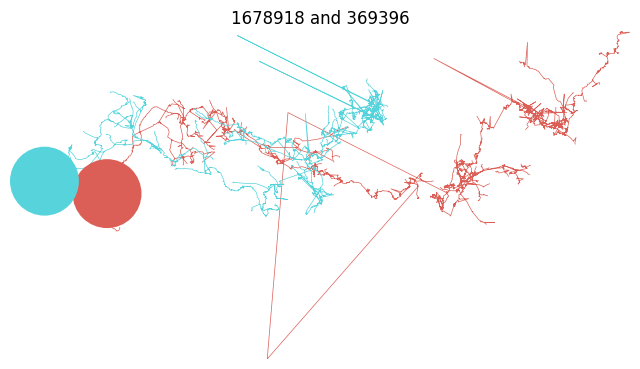

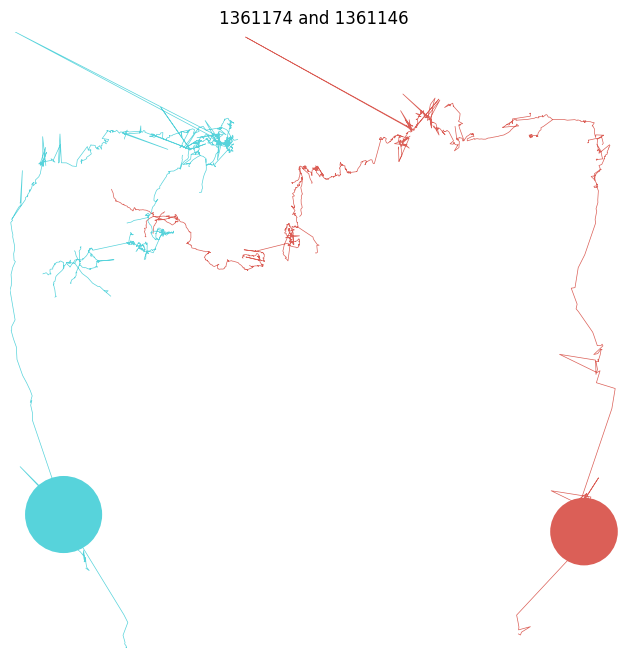

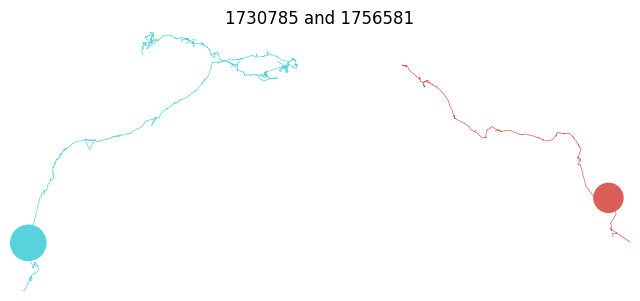

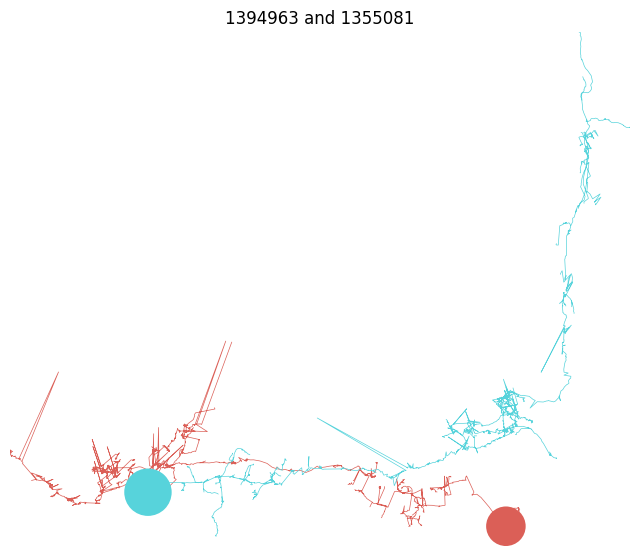

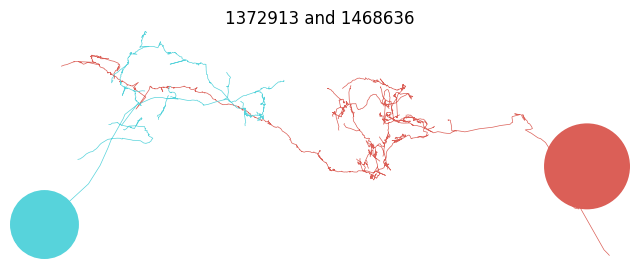

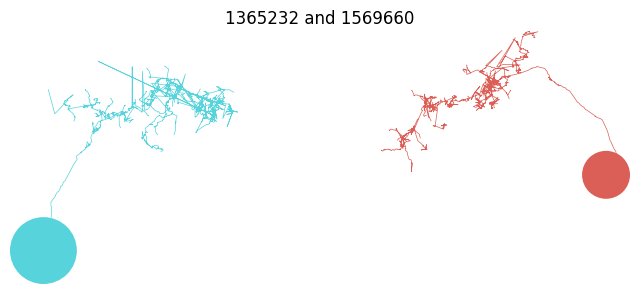

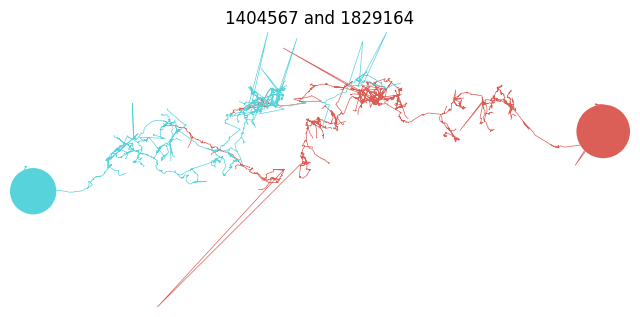

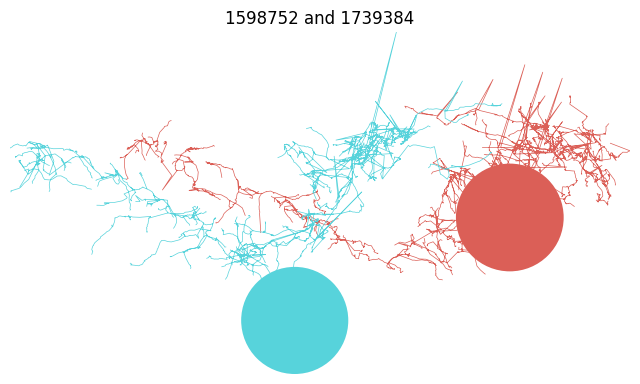

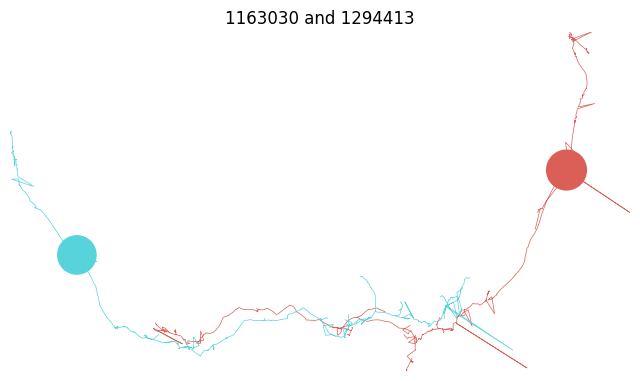

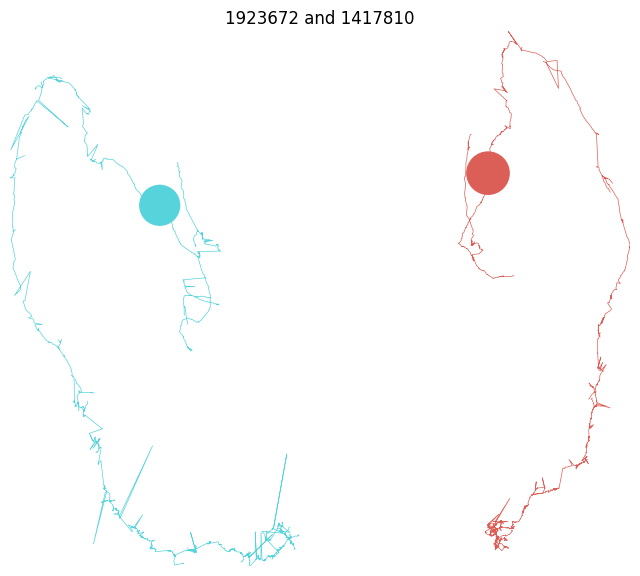

In [44]:
for i in range(len(neuron_list)):
    fig, ax = navis.plot2d(neuron_list[i], method='2d', view=('x', '-y'))
    left = correct_sub_df.loc[i, "skid-ID LEFT"]
    right = correct_sub_df.loc[i, "skid-ID RIGHT"]
    ax.set_title(f"{left} and {right}")

Take the norm of our subgraphs from graph matching

In [45]:
#norms of matched adjs
#subset and permute the adjacencies by their indices from matching
np_sub_left_adj_matched = np_sub_left_adj[np.ix_(sub_ind_left, sub_ind_left)]
np_sub_right_adj_matched = np_sub_right_adj[np.ix_(sub_ind_right, sub_ind_right)]

#calculate norm of difference of matched adjacencies
np_sub_diff_adj_matched = np_sub_left_adj_matched - np_sub_right_adj_matched
sub_diff_matched_norm = np.linalg.norm(np_sub_diff_adj_matched)

print(f"Norm of difference of left and right matched adjs: {sub_diff_matched_norm}")

Norm of difference of left and right matched adjs: 74.02702209328699


In [46]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms = []
rng = default_rng()
for _ in range(n_iters):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_left_adj_rand = np_sub_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_right_adj_rand = np_sub_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_diff_adj_rand = np_sub_left_adj_rand - np_sub_right_adj_rand
    sub_diff_rand_norm = np.linalg.norm(np_sub_diff_adj_rand)
    rand_norms.append(sub_diff_rand_norm)

#print(f"Norm of difference of left and right randomly permuted adjs: {sub_diff_rand_norm}")

Text(0.5, 1.0, 'Norm of difference of matched vs random adjacencies (sub) (matched norm: 74.02702209328699)')

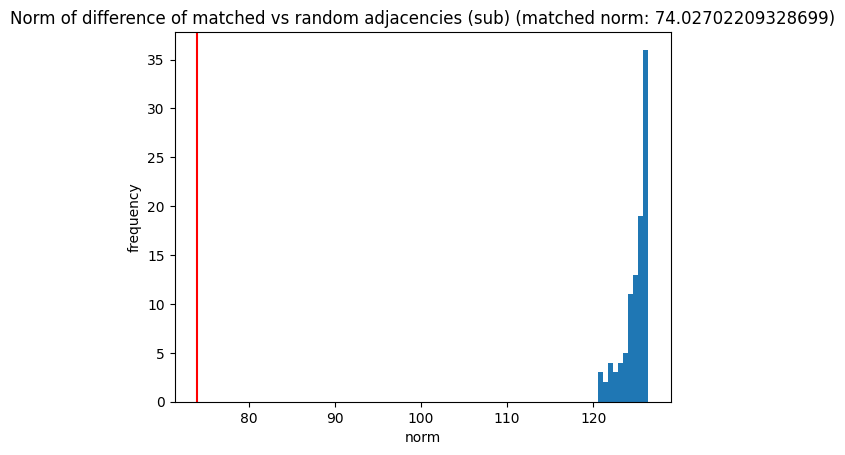

In [47]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms)
ax.axvline(sub_diff_matched_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random adjacencies (sub) (matched norm: {})".format(sub_diff_matched_norm))

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [48]:
#first move all the right skids that are in Nadine's list to the front of the right skids list
#note: doing right skids instead of left skids first because will go out of bounds when starting with left skids
sub_right_skids_copy = np.array(sub_right_skids)

#find right indices that correspond to Nadine's list
sub_inds_nadine = [list(np.where(sub_right_skids_copy == j)[0]) for j in right_true]

#modify inds_nadine to get rid of all empty lists and make list elements as ints
sub_inds_nadine_filt = [ele[0] for ele in sub_inds_nadine if ele != []]
sub_inds_nadine_filt = np.array(sub_inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in sub_right_skids_copy
sub_skids_right_nadine = sub_right_skids_copy[sub_inds_nadine_filt]
sub_skids_right_not_nadine = [skid for skid in sub_right_skids_copy if skid not in sub_skids_right_nadine]
sub_skids_right_not_nadine = np.array(sub_skids_right_not_nadine)

#now concatenate the nadine skids and not_nadine right skids
sub_skids_right_form = np.append(sub_skids_right_nadine, sub_skids_right_not_nadine, axis=0)

#now permute the left index list such that the pairs align with Nadine's
sub_left_skids_copy = np.array(sub_left_skids)

#go through the first entries of right_skids_copy and find the left_skid that corresponds to it in true_pairs
for i in range(len(sub_inds_nadine_filt)):
    
    #get the left skid which exists in nadine's pairs
    right_skid = sub_skids_right_form[i]

    #find the left skid that corresponds to the left_skid in true_pair
    sub_ind_pair = true_pairs.loc[true_pairs["skid-ID RIGHT"] == sub_skids_right_form[i]].index[0]
    left_skid = true_pairs.loc[sub_ind_pair, "skid-ID LEFT"]

    #find where this left_skid is in the left_skids list, if it is not there then continue
    if left_skid not in sub_left_skids_copy:
        continue
    
    else:
        #swap left_skid with the skid where it needs to go
        ind_left_curr = np.where(sub_left_skids_copy == left_skid)[0][0]
        temp = sub_left_skids_copy[i]
        sub_left_skids_copy[i] = left_skid
        sub_left_skids_copy[ind_left_curr] = temp
        
sub_skids_left_form = sub_left_skids_copy.copy()

Calculate the accuracy on our subgraphs after initialization without graph matching

In [49]:
#Accuracy for SUB, NADINE, NADINE
sub_nadine_nadine_pairs = pd.DataFrame(list(zip(sub_skids_left_form, sub_skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

#merge the true pairs and our matched pairs by their union
sub_nadine_df = pd.merge(true_pairs, sub_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = sub_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))


The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9461538461538461


Calculate the norm of our subgraphs after initialization without graph matching

In [50]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
sub_skids_left_form_trunc = sub_skids_left_form[0:len(sub_skids_right_form)]

#make adjs
sub_nadine_left_adj = pymaid.adjacency_matrix(sub_skids_left_form)
sub_nadine_left_adj_trunc = pymaid.adjacency_matrix(sub_skids_left_form_trunc)
sub_nadine_right_adj = pymaid.adjacency_matrix(sub_skids_right_form)

np_sub_nadine_left_adj = np.array(sub_nadine_left_adj)
np_sub_nadine_left_adj_trunc = np.array(sub_nadine_left_adj_trunc)
np_sub_nadine_right_adj = np.array(sub_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_sub_nadine = np_sub_nadine_left_adj_trunc - np_sub_nadine_right_adj
diff_sub_nadine_norm = np.linalg.norm(np_diff_sub_nadine)

print(f"Norm of difference of left and right subgraph Nadine initialized adjs: {diff_sub_nadine_norm}")

Norm of difference of left and right subgraph Nadine initialized adjs: 76.69419795525604


In [51]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_sub_nadine = []
rng = default_rng()
for _ in range(n_iters):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj_trunc), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of matched (on sub adjs) vs random adjacencies (norm: 76.69419795525604)')

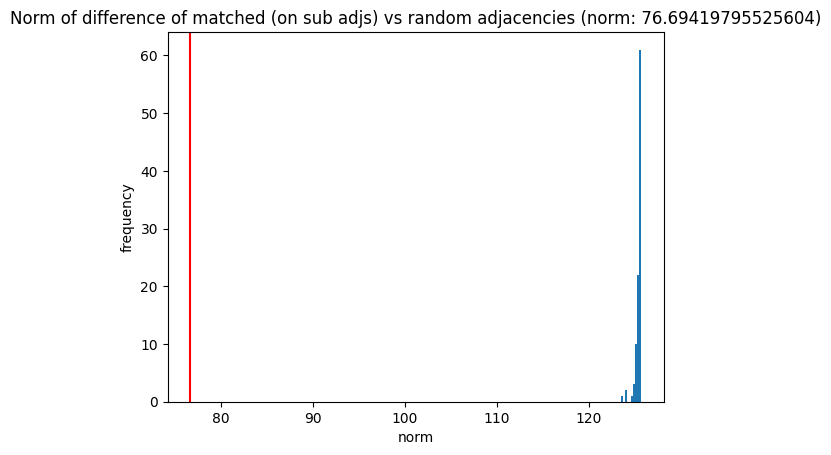

In [52]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on sub adjs) vs random adjacencies (norm: {})".format(diff_sub_nadine_norm))

Run graph matching on our subgraphs after initialization

In [53]:
#SUB, NADINE, OPT
sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_nadine_left_adj, np_sub_nadine_right_adj)

In [54]:
#SUB, NADINE, OPT
sub_score_align

5292.0

In [55]:
sub_skids_left_form_matched = sub_skids_left_form[sub_nadine_ind_left]
sub_skids_right_form_matched = sub_skids_right_form[sub_nadine_ind_right]

#make dataframe for the matched pairs
sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
sub_nadine_matched_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,608460
1,10536,1411593
2,6743,1160628
3,151847,1123072
4,12115,189615
...,...,...
255,1588419,1135395
256,1292334,1356982
257,1848592,1567572
258,1356253,1348770


Accuracy on our subgraphs after initialization and graph matching

In [56]:
#SUB, NADINE, OPT

#merge the true pairs and our matched pairs by their union
sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = sub_nadine_matched_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.05384615384615385


Calculate norm of our subgraphs after initialization and graph matching

In [57]:
#norms of sub nadine init opt adjs

#subset and permute the adjacencies by their indices from matching
np_sub_nadine_matched_left_adj = np_sub_nadine_left_adj[np.ix_(sub_nadine_ind_left, sub_nadine_ind_left)]
np_sub_nadine_matched_right_adj = np_sub_nadine_right_adj[np.ix_(sub_nadine_ind_right, sub_nadine_ind_right)]

#calculate norm of difference of matched adjacencies
np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)

print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 73.74957626996917


In [58]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_sub_nadine = []
rng = default_rng()
for _ in range(n_iters):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_sub_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of matched (on sub adjs) vs random adjacencies (matched norm: 73.74957626996917)')

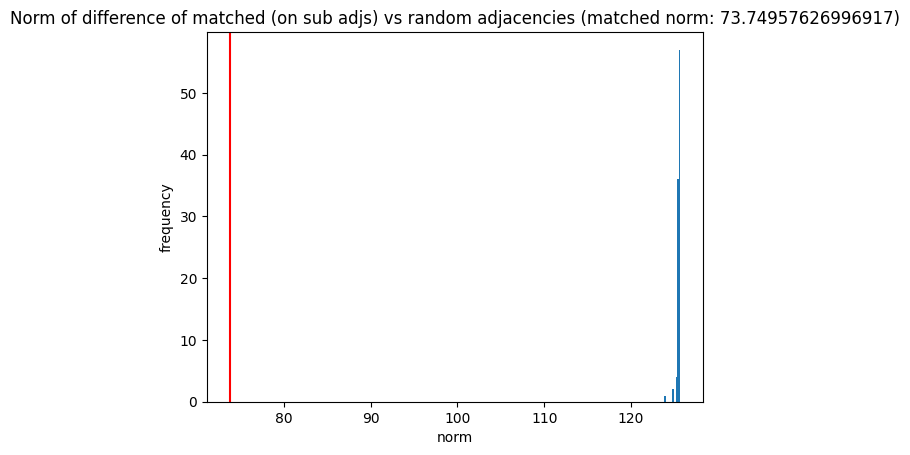

In [59]:
#histogram of SUB NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_nadine_matched_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on sub adjs) vs random adjacencies (matched norm: {})".format(diff_sub_nadine_matched_norm))

In [60]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)
numbers

array([18, 19,  9,  0, 11,  2, 15,  4, 17, 12])

In [61]:
x = np.linspace(0, 1, 3)
y = np.linspace(0, 1, 2)
xv, yv = np.meshgrid(x, y)
xv

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])

In [62]:
n1 = np.arange(5)
n2 = np.arange(4)
a = np.arange(100)
a.shape = (10,10)
a[np.ix_(n1, n2)]

array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33],
       [40, 41, 42, 43]])

We will construct a permutation matrix P such that PBP^T causes correspondance to Nadine's pairs for both the subgraphs and the whole graphs

- Let's say we are at row i in our left subgraph, and obviously since this is a subgraph of the Nadine paired neurons, the skid of this row is going to be in the left true list since it has been matched by Nadine
    - If we go through the whole adjs, then if the left neuron is not in the true_pairs, then continue to next row in left graph
- Need to go through true_pairs to find the right neuron that our current left neuron corresponds to, and need to find the row where this neuron is in the right subgraph
    - In this row put a 1 in position i and a 0 everywhere else in the row
    - Keep track of the i's in which we fill the corresponding rows out
    - If we go through the right graph and the right neuron that we found earlier is not a skid in the right graph, then continue to next row in left graph
- In the rows of the right graph we did not examine put a 1 in a random spot that does not correspond to an i and 0's elsewhere
    - Keep track of each spot where the 1 was added in these random rows, cannot add a 1 in a differnt row in that same spot
- After constructing permutation matrix P, then do PBP^T, then do next steps



Optimization methods

- Nadine's pairs: make permutation matrix to correspond to Nadine's pairs in previous step and calculate accuracy and norm (can't do for default because need permutation matrix) (both subgraph and whole) (?)
- Opt: run graph matching and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole) see if score from graph matching with default initialization is worse than if initializing with permutation matrix
- Random: do random permutations of the rows of the right graph and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole)
- Focus on whole adjs

- Look at graph matching for the whole left and right graphs and compute accuracy and norm histogram (make sure to subset Nadine's true pairs correctly) (ensure accuracy is calculated correctly: look at picture of board to see how that is done)
- Show morphologies for 10 of the pairs that we matched that are not in Nadine's and 10 of the pairs that Nadine matched that are not in ours 
- Calculate norms for several situations (Nadine's subgraphs vs whole graphs, default init vs Nadine init (make permutation matrix such that PBP^T causes correspondance to Nadine's pairs (can verify with Pedigo after making)) optimization method (use nadine's pairs straightup on the subgraph, graph matching, random))
- (Note: when constructing permutation matrix to correspond to Nadine's pairs when using the entire whole graphs, can use random entries for the rows that do not correspond to Nadine's pairs (refer to "up" on graph: rows for permutation matrix there will be random))

- Make Gantt Chart timeline for what I need to get done
- Make permutation matrix by extracting the left and right skids and then rearranging the right skids such that it matches Nadine's pairs and then make adjacency matrix for right by reindexing, then the permutation matrix would be identity
- Get accuracies and norms for default and Nadine init with diff optimization methods (focus on Nadine's pairs and whole adjs), look at score from graph matching with default and see if worse than if initializing with permutation matrix 

- Go through Nadine's pairs, and find the pairs where the left neuron exists in our left skids and the right neurons exists in our right skids
    - L1: list of left neurons here, R1: list of right neurons here
- Go through our left and right skids, collect the skids that are not in L1 and R1, call these lists L2 and R2
- Shuffle L2 and R2
- L3 = L1 + L2, R3 = R1 + R2
- Extract adjacencies using these lists of skids using pymaid
- Run graph matching on adjacencies using an init parameter which will be an identity matrix the size of the larger of the two matrices
- Calculate norm and accuracy from graph matching

Do the initialization on the whole graph

In [63]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
whole_left_skids_in_pairs = []
whole_right_skids_in_pairs = []

for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids):
        whole_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        whole_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [64]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
whole_left_skids_not_pairs = np.array([skid for skid in left_skids if skid not in whole_left_skids_in_pairs])
whole_right_skids_not_pairs = np.array([skid for skid in right_skids if skid not in whole_right_skids_in_pairs])

#shuffle the lists
rand_ind_left = rng.choice(len(whole_left_skids_not_pairs), size=len(whole_left_skids_not_pairs), replace=False)
whole_left_skids_not_pairs_rand = whole_left_skids_not_pairs[rand_ind_left]

rand_ind_right = rng.choice(len(whole_right_skids_not_pairs), size=len(whole_right_skids_not_pairs), replace=False)
whole_right_skids_not_pairs_rand = whole_right_skids_not_pairs[rand_ind_right]

In [65]:
#concatenate the pairs and not pairs lists
whole_left_skids_to_match = np.append(whole_left_skids_in_pairs, whole_left_skids_not_pairs_rand, axis=0)
whole_right_skids_to_match = np.append(whole_right_skids_in_pairs, whole_right_skids_not_pairs_rand, axis=0)

#grab the adjacency matrices
whole_left_adj_to_match = left_adj.loc[whole_left_skids_to_match, whole_left_skids_to_match]
whole_right_adj_to_match = right_adj.loc[whole_right_skids_to_match, whole_right_skids_to_match]

np_whole_left_adj_to_match = np.array(whole_left_adj_to_match)
np_whole_right_adj_to_match = np.array(whole_right_adj_to_match)

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
perm_mat = np.eye(max(len(whole_left_skids_to_match), len(whole_right_skids_to_match)))


In [66]:
#graph match with initialization on whole graph
whole_nadine_ind_left, whole_nadine_ind_right, whole_score_align, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, init=perm_mat)

In [67]:
whole_score_align

22694.0

In [68]:
whole_skids_left_form_matched = whole_left_skids_to_match[whole_nadine_ind_left]
whole_skids_right_form_matched = whole_right_skids_to_match[whole_nadine_ind_right]

#make dataframe for the matched pairs
whole_nadine_matched_pairs = pd.DataFrame(list(zip(whole_skids_left_form_matched, whole_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
whole_nadine_matched_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,59671
1,10536,40141
2,6743,23921
3,151847,27917
4,12115,26163
...,...,...
1335,1027923,1586304
1336,1448388,1551483
1337,206767,184928
1338,1322525,593849


In [69]:
#WHOLE, NADINE, OPT

#merge the true pairs and our matched pairs by their union
whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = whole_nadine_matched_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.25984251968503935


In [70]:
#norms of whole init opt adjs

#subset and permute the adjacencies by their indices from matching
np_whole_nadine_matched_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left, whole_nadine_ind_left)]
np_whole_nadine_matched_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right, whole_nadine_ind_right)]

#calculate norm of difference of matched adjacencies
np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)

print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 156.83430747129276


In [71]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_whole_nadine = []
rng = default_rng()
for _ in range(n_iters):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of matched (on whole adjs) vs random adjacencies after initialization (matched norm: 156.83430747129276)')

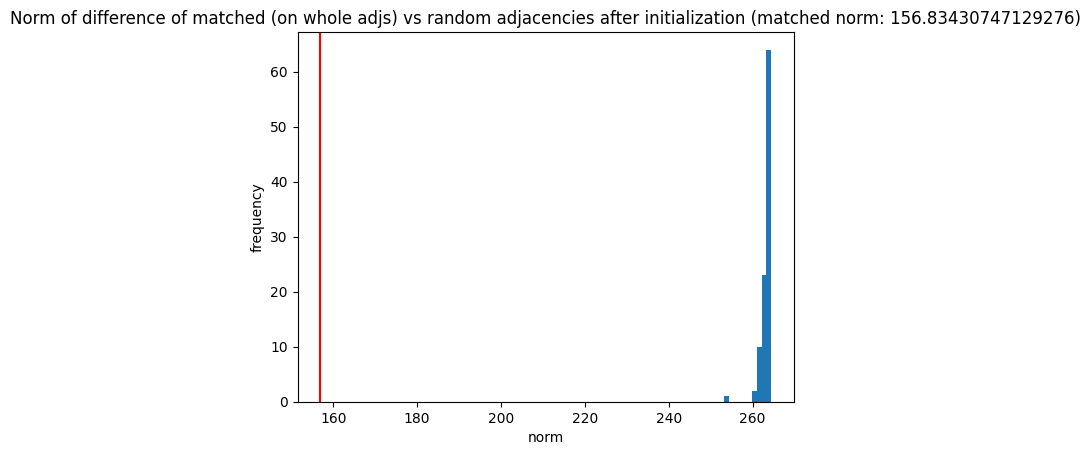

In [72]:
#histogram of WHOLE INIT OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_nadine_matched_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on whole adjs) vs random adjacencies after initialization (matched norm: {})".format(diff_whole_nadine_matched_norm))

Now we do the same initialization but on the subgraph of the left and right neurons

In [73]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
sub_left_skids_in_pairs = []
sub_right_skids_in_pairs = []

for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in sub_left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in sub_right_skids):
        sub_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        sub_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [74]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
sub_left_skids_not_pairs = np.array([skid for skid in sub_left_skids if skid not in sub_left_skids_in_pairs])
sub_right_skids_not_pairs = np.array([skid for skid in sub_right_skids if skid not in sub_right_skids_in_pairs])

#shuffle the lists
rand_ind_left = rng.choice(len(sub_left_skids_not_pairs), size=len(sub_left_skids_not_pairs), replace=False)
sub_left_skids_not_pairs_rand = sub_left_skids_not_pairs[rand_ind_left]

rand_ind_right = rng.choice(len(sub_right_skids_not_pairs), size=len(sub_right_skids_not_pairs), replace=False)
sub_right_skids_not_pairs_rand = sub_right_skids_not_pairs[rand_ind_right]

In [75]:
#concatenate the pairs and not pairs lists
sub_left_skids_to_match = np.append(sub_left_skids_in_pairs, sub_left_skids_not_pairs_rand, axis=0)
sub_right_skids_to_match = np.append(sub_right_skids_in_pairs, sub_right_skids_not_pairs_rand, axis=0)

sub_left_skids_to_match = sub_left_skids_to_match.astype(int)
sub_right_skids_to_match = sub_right_skids_to_match.astype(int)

#grab the adjacency matrices
sub_left_adj_to_match = sub_left_adj.loc[sub_left_skids_to_match, sub_left_skids_to_match]
sub_right_adj_to_match = sub_right_adj.loc[sub_right_skids_to_match, sub_right_skids_to_match]

np_sub_left_adj_to_match = np.array(sub_left_adj_to_match)
np_sub_right_adj_to_match = np.array(sub_right_adj_to_match)

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
sub_perm_mat = np.eye(max(len(sub_left_skids_to_match), len(sub_right_skids_to_match)))


In [76]:
#graph match with initialization on subgraphs
sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, init=sub_perm_mat)

In [77]:
sub_score_align

5719.0

In [78]:
sub_skids_left_form_matched = sub_left_skids_to_match[sub_nadine_ind_left]
sub_skids_right_form_matched = sub_right_skids_to_match[sub_nadine_ind_right]

sub_skids_left_form_matched = sub_skids_left_form_matched.astype(str)
sub_skids_right_form_matched = sub_skids_right_form_matched.astype(str)

#make dataframe for the matched pairs
sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
sub_nadine_matched_pairs

,skid-ID LEFT,skid-ID RIGHT
0,7501,59671
1,10536,24659
2,6743,23921
3,151847,27917
4,12115,26163
...,...,...
255,1349072,1434961
256,1356560,1244182
257,1700859,1306131
258,1356253,1280329


In [79]:
#SUB, NADINE, OPT

#merge the true pairs and our matched pairs by their union
sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = sub_nadine_matched_df["Exist"].value_counts()["both"]
print(num)
#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num

print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

103
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.39615384615384613


In [80]:
#norms of sub init opt adjs

#subset and permute the adjacencies by their indices from matching
np_sub_nadine_matched_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left, sub_nadine_ind_left)]
np_sub_nadine_matched_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right, sub_nadine_ind_right)]

#calculate norm of difference of matched adjacencies
np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)

print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 67.63135367564367


In [81]:
#norms of randomly permuted adjs
from numpy.random import default_rng

#do 100 times to make histogram
n_iters = 100
rand_norms_sub_nadine = []
rng = default_rng()
for _ in range(n_iters):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_left_adj_to_match_rand = np_sub_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_right_adj_to_match_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_left_adj_to_match_rand - np_sub_right_adj_to_match_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

Text(0.5, 1.0, 'Norm of difference of matched (on sub adjs) vs random adjacencies after initialization (matched norm: 67.63135367564367)')

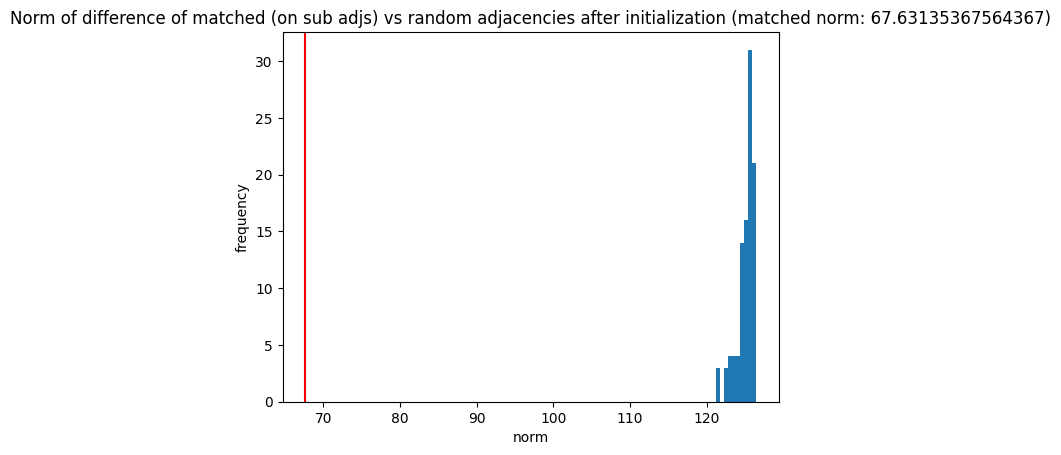

In [82]:
#histogram of SUB INIT OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_nadine_matched_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched (on sub adjs) vs random adjacencies after initialization (matched norm: {})".format(diff_sub_nadine_matched_norm))